# **dataset 2: Triple MNIST**

## Step-by-Step Guide to Build a CNN for Multi-Label Classification Problems:

### 1. Import Libraries and Function

Begin by importing all the required libraries and functions for data processing, model building, and evaluation.

### 2. Load the Dataset
Load the training, validation, and test datasets from the specified directories.

### 3. Preprocess the Dataset

- Reshape: Adjust the shape of the data to fit the model input requirements.
- Normalize Pixel Values: Scale the pixel values to the range [0, 1].
- Define Number of Categories: Specify the number of categories for each digit position.
- Flatten: Convert multi-dimensional arrays to a single dimension.
- Convert Labels to Categorical: Use one-hot encoding to convert labels for multi-label classification.
- Flatten Label Lists: Convert the label lists to dictionaries for multi-output models.
- Custom Data Generator: Define a custom data generator to yield batches of data during training.

### 4. Define Learning Rate and K-Fold Cross Validation
- Set up a learning rate scheduler to adjust the learning rate during training.
- Use K-fold cross-validation to better estimate model performance.

### 5. Set Up Callbacks for Early Stopping, Model Checkpoint, and TensorBoard
Configure callbacks for early stopping, saving the best model, and logging training progress for visualization in TensorBoard.
Implement early stopping to prevent overfitting by stopping training when the validation loss stops improving.

### 6. Define Function to Plot Learning Curves
Create a function to visualize training and validation accuracy and loss over epochs.

### 7. Define the CNN Model Architecture
Set Up the Input Shape. Build the CNN model architecture.
To be compared:
The last layer/ Output layer uses a sigmoid versus softmax.
The loss function uses categorical crossentropy versus binary crossentropy.

### 8. Train the Model
Train the model using the training data and validate it on the validation data, while using the defined callbacks.

### 9. Evaluate the Model
Evaluate the model and print the accuracy and loss metrics.

### 10. Perform Hyperparameter tuning 
- Perform 'keras-tuner' tuning to identify the best model parameters.
- Apply regularization techniques to prevent overfitting.
- Use cross-validation to obtain a more reliable estimate of the model's performance.

### 11. Re-Evaluate the Model
Re-Evaluate the model after Hyperparameter Tuning.

### 12. Final evaluation on the Test set
After finishing all the training and testing on the validation data, we trained the model one last time on all the training data. Then, we tested it on a completely new set of data that the model had never seen before (the Test set). This final evaluation checks how well the model performs on totally new data, making sure it’s ready for real life.

##  **1. Import necessary libraries and functions.**

In [1]:
%pip install -qqq keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.utils import plot_model

from keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')

## **2. Load the Dataset**

In [3]:
def load_images_from_folder(folder, img_size=(28, 28)):
    images = []
    labels = []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            label = [int(digit) for digit in subdir]  # the subdir name is the label
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                try:
                    img = Image.open(img_path).convert('L')
                    img = img.resize(img_size)
                    img = np.array(img)
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Failed to process image {img_path}: {e}")
    return np.array(images), np.array(labels)


In [4]:
# Define the directories
train_dir = r'dataset2/train'
test_dir = r'dataset2/test'
val_dir = r'dataset2/val'

print("Train directory contains:", os.listdir(train_dir))
print("Validation directory contains:", os.listdir(val_dir))
print("Test directory contains:", os.listdir(test_dir))

Train directory contains: ['000', '004', '005', '006', '007', '009', '011', '013', '015', '018', '020', '021', '022', '023', '024', '026', '027', '028', '030', '031', '032', '033', '034', '035', '036', '037', '038', '040', '041', '042', '043', '045', '048', '049', '050', '052', '054', '055', '057', '059', '061', '062', '063', '064', '066', '070', '071', '072', '074', '075', '078', '079', '080', '082', '084', '085', '089', '090', '091', '093', '094', '095', '097', '100', '101', '102', '103', '104', '105', '107', '110', '114', '115', '116', '117', '118', '119', '120', '121', '122', '124', '125', '127', '128', '131', '132', '134', '138', '142', '145', '147', '148', '150', '151', '153', '155', '156', '157', '159', '160', '161', '162', '163', '164', '165', '166', '167', '169', '170', '171', '172', '174', '175', '177', '178', '179', '181', '182', '183', '184', '185', '188', '189', '190', '191', '192', '195', '196', '199', '200', '201', '202', '203', '204', '205', '209', '210', '211', '212', 

In [5]:
# Load the datasets
X_train, y_train = load_images_from_folder(train_dir, img_size=(28, 28))
X_val, y_val = load_images_from_folder(val_dir, img_size=(28, 28))
X_test, y_test = load_images_from_folder(test_dir, img_size=(28, 28))

In [6]:
X_train.shape

(64000, 28, 28, 1)

In [7]:
X_train.dtype

dtype('uint8')

In [8]:
X_train.min()

0

In [9]:
X_train.max()

255

In [10]:
#X_train[0]

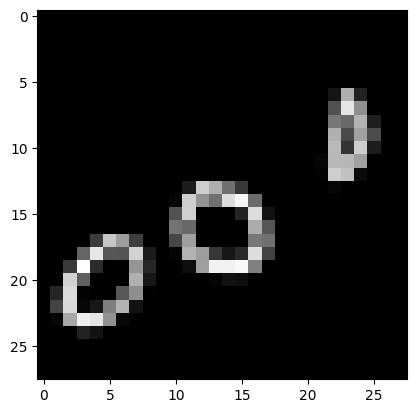

In [11]:
image = X_train[0]
plt.imshow(image, cmap = 'gray')

we can now see that this is a 28x28 pixel image of a 000. The answer is in the y_train data, which contains correct labels for the data

In [12]:
y_train[0]

array([0, 0, 0])

In [13]:
X_test.shape

(20000, 28, 28, 1)

In [14]:
X_val.shape

(16000, 28, 28, 1)

In [15]:
# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
for i in range(3):
    print(f"y_train[{i}] shape: {y_train[i].shape}")
print(f"X_val shape: {X_val.shape}")
for i in range(3):
    print(f"y_val[{i}] shape: {y_val[i].shape}")
print(f"X_test shape: {X_test.shape}")
for i in range(3):
    print(f"y_test[{i}] shape: {y_test[i].shape}")

X_train shape: (64000, 28, 28, 1)
y_train[0] shape: (3,)
y_train[1] shape: (3,)
y_train[2] shape: (3,)
X_val shape: (16000, 28, 28, 1)
y_val[0] shape: (3,)
y_val[1] shape: (3,)
y_val[2] shape: (3,)
X_test shape: (20000, 28, 28, 1)
y_test[0] shape: (3,)
y_test[1] shape: (3,)
y_test[2] shape: (3,)


## **3. Preprocess the Dataset**

In [16]:
#X_train[0]

In [17]:
# Normalize pixel values to scale the pixel values to the range [0, 1].

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [18]:
# Ensure the images have the correct shape for CNN input
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [19]:
X_train.shape

(64000, 28, 28, 1)

We can now see that the values are all floating between 0.0 and 1.0 after Normalized

In [20]:
X_train.dtype

dtype('float32')

In [21]:
X_train.min()

0.0

In [22]:
X_train.max()

1.0

In [23]:
# Number of categories for each digit position
num_categories = 10

In [24]:
# Convert labels to categorical (one-hot encoding)
y_train = [to_categorical([label[i] for label in y_train], num_categories) for i in range(3)]
y_val = [to_categorical([label[i] for label in y_val], num_categories) for i in range(3)]
y_test = [to_categorical([label[i] for label in y_test], num_categories) for i in range(3)]

In [25]:
# Flatten the label lists to dictionaries
y_train_dict = {f'digit_{i}': y_train[i] for i in range(3)}
y_val_dict = {f'digit_{i}': y_val[i] for i in range(3)}
y_test_dict = {f'digit_{i}': y_test[i] for i in range(3)}

In [26]:
y_train

[array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])]

In [27]:
# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
for i in range(3):
    print(f"y_train[{i}] shape: {y_train[i].shape}")
print(f"X_val shape: {X_val.shape}")
for i in range(3):
    print(f"y_val[{i}] shape: {y_val[i].shape}")
print(f"X_test shape: {X_test.shape}")
for i in range(3):
    print(f"y_test[{i}] shape: {y_test[i].shape}")

X_train shape: (64000, 28, 28, 1)
y_train[0] shape: (64000, 10)
y_train[1] shape: (64000, 10)
y_train[2] shape: (64000, 10)
X_val shape: (16000, 28, 28, 1)
y_val[0] shape: (16000, 10)
y_val[1] shape: (16000, 10)
y_val[2] shape: (16000, 10)
X_test shape: (20000, 28, 28, 1)
y_test[0] shape: (20000, 10)
y_test[1] shape: (20000, 10)
y_test[2] shape: (20000, 10)


In [28]:
y_train[0:9]

[array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])]

In [29]:
y_train_dict

{'digit_0': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_1': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_2': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])}

In [30]:
y_val_dict

{'digit_0': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_1': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'digit_2': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])}

In [31]:
# Custom Data Generator

def custom_data_generator(X, y, batch_size):
    while True:
        idx = np.random.permutation(len(X))
        X = X[idx]
        y = {key: y[key][idx] for key in y}
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = {key: y[key][i:i + batch_size] for key in y}
            yield X_batch, y_batch

## **4. Define Learning Rate and K-Fold Cross Validation**

In [32]:
#Set up learning rate scheduler to adjust the learning rate during training.

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    return lr

In [33]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [34]:
# K-Fold Cross Validation
kf = KFold(n_splits=2, shuffle=True)

k=2 to save time and resources.  With fewer folds, the training process will be faster because there are fewer iterations.

## **5. Set Up Callbacks for Early Stopping**
Configure callbacks for early stopping, saving the best model, and logging training progress for visualization in TensorBoard. Implement early stopping to prevent overfitting by stopping training when the validation loss stops improving.

In [35]:
# Callback for early stopping with adjusted patience.
# If the validation loss does not improve for 20 consecutive epochs, training will stop early.

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

The early stopping callback is used/ triggered to stop training early if the validation loss does not improve for a certain number of epochs (patience). 

## **6. Define Function to Plot Learning Curves**
Create a function to visualize training and validation accuracy and loss over epochs.

In [43]:
def plot_learning_curves(history):
    acc = [history.history[f'digit_{i}_accuracy'] for i in range(3)]
    val_acc = [history.history[f'val_digit_{i}_accuracy'] for i in range(3)]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    for i in range(3):
        plt.plot(epochs, acc[i], label=f'Training accuracy digit_{i}')
        plt.plot(epochs, val_acc[i], label=f'Validation accuracy digit_{i}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## 7/8/9. CNN Model with Activation: *_Sigmoid_*, Loss function: *_Categorical Cross Entropy_*

### 7A. Define the CNN Model

For multi-label classification, the last layer in the model should uses a sigmoid function for label prediction, and the training process should uses a binary_crossentropy function as the loss function. 

But for comparison purpose, we will use loss='categorical_crossentropy' function as the loss function first.

In [38]:
def create_cnn_model_sgcc():
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = [Dense(10, activation='sigmoid', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',  # usually categorical_crossentropy is for multi-class classification, not for multi-label classification.
        optimizer='adam',
        metrics={f'digit_{i}': 'accuracy' for i in range(3)}
    )
    return model

# Example usage
model = create_cnn_model_sgcc()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 13, 13,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 5, 64)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1600)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    409,856 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_0 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_2 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,382 (1.66 MB)

 Trainable params: 436,382 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

### 8A. Train the Model

In [40]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_sgcc()  # Using CNN model instead of Dense model

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=128),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]
    )

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - digit_0_accuracy: 0.1846 - digit_1_accuracy: 0.1818 - digit_2_accuracy: 0.1658 - loss: 6.8737 - val_digit_0_accuracy: 0.6576 - val_digit_1_accuracy: 0.7312 - val_digit_2_accuracy: 0.6023 - val_loss: 3.7390 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - digit_0_accuracy: 0.5968 - digit_1_accuracy: 0.6299 - digit_2_accuracy: 0.5100 - loss: 3.9484 - val_digit_0_accuracy: 0.8424 - val_digit_1_accuracy: 0.8701 - val_digit_2_accuracy: 0.7859 - val_loss: 2.4118 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - digit_0_accuracy: 0.7218 - digit_1_accuracy: 0.7494 - digit_2_accuracy: 0.6527 - loss: 3.0825 - val_digit_0_accuracy: 0.8796 - val_digit_1_accuracy: 0.8877 - val_digit_2_accuracy: 0.8275 - val_loss: 2.0441 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - digit_0_accuracy: 0.7703 - digit_1_accuracy: 0.7906 - digit_2_accuracy: 0.7100 - loss

### 9A. Evaluate The Model Performance

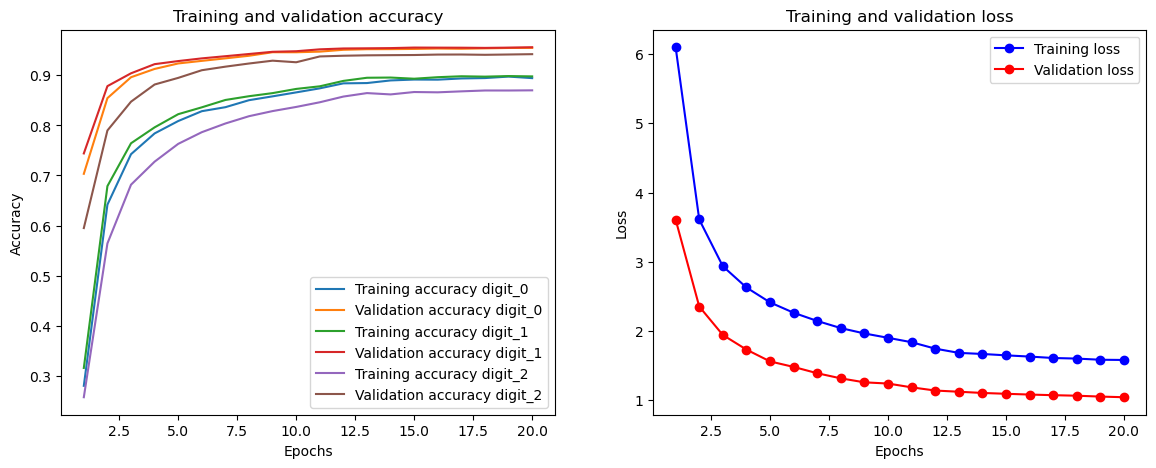

In [44]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### Interpretation

There is high accuracy on the training and validation set. Training and validation loss decreasing significantly. That means the model is good, not underfitting nor overfitting. The lowest loss using 'categorical-crossentropy' as the loss function is around  is around 1.5

### Evaluation on the test set


We test it on a completely new set of data that the model had never seen before (the Test set) to check how well the model performs on totally new data, making sure it’s ready for real life.

In [45]:
# Evaluation on the test set
model = create_cnn_model_sgcc()  # Using CNN model with 'categorical_crossentropy' function as the loss function

history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=32),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

# Evaluate the model on the test set
test_metrics = model.evaluate(X_test, y_test_dict)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1:]

print(f'Test loss: {test_loss}')
for i, acc in enumerate(test_accuracy):
    print(f'Test accuracy for digit_{i}: {acc}')

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - digit_0_accuracy: 0.2728 - digit_1_accuracy: 0.2951 - digit_2_accuracy: 0.2367 - loss: 6.1547 - val_digit_0_accuracy: 0.8548 - val_digit_1_accuracy: 0.8597 - val_digit_2_accuracy: 0.7729 - val_loss: 2.4846 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - digit_0_accuracy: 0.7345 - digit_1_accuracy: 0.7539 - digit_2_accuracy: 0.6528 - loss: 3.1383 - val_digit_0_accuracy: 0.9007 - val_digit_1_accuracy: 0.9082 - val_digit_2_accuracy: 0.8576 - val_loss: 1.9323 - learning_rate: 0.0010
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - digit_0_accuracy: 0.7936 - digit_1_accuracy: 0.8010 - digit_2_accuracy: 0.7335 - loss: 2.6731 - val_digit_0_accuracy: 0.9201 - val_digit_1_accuracy: 0.9270 - val_digit_2_accuracy: 0.8866 - val_loss: 1.6696 - learning_rate: 0.0010
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - digit_0_accuracy: 0.8241 - digit_1_accuracy: 0.8275 - digit_2_accuracy: 0.7694

### Interpretation

There is high accuracy on the test set which the model has never seen before, that means the model can predict well on the new unseen data.
The lowest loss using 'categorical-crossentropy' as the loss function is around  is around 0.9

## 7/8/9. CNN Model with Activation: *_Sigmoid_*, Loss function: *_Binary Cross Entropy_*

### 7B. Define the CNN Model

For multi-label classification, the training process should uses a binary_crossentropy function as the loss function.

In [53]:
def create_cnn_model_sgbc():
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = [Dense(10, activation='sigmoid', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',  # Binary_crossentropy for multi-label classification
        optimizer='adam',
        metrics={f'digit_{i}': 'accuracy' for i in range(3)}
    )
    return model

# Example usage
model = create_cnn_model_sgbc()
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 26, 26,    │        320 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 13, 13,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 13, 13,    │          0 │ max_pooling2d_24… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 11, 11,    │     18,496 │ dropout_36[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 5, 5, 64)  │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 5, 5, 64)  │          0 │ max_pooling2d_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 1600)      │          0 │ dropout_37[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    409,856 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 256)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_0 (Dense)     │ (None, 10)        │      2,570 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_2 (Dense)     │ (None, 10)        │      2,570 │ dropout_38[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,382 (1.66 MB)

 Trainable params: 436,382 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

### 8B. Train the Model

In [54]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_sgbc()  # Using CNN model with 'binary_crossentropy' function as the loss function

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=128),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - digit_0_accuracy: 0.1043 - digit_1_accuracy: 0.1056 - digit_2_accuracy: 0.1031 - loss: 1.3526 - val_digit_0_accuracy: 0.2121 - val_digit_1_accuracy: 0.2536 - val_digit_2_accuracy: 0.1408 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - digit_0_accuracy: 0.2276 - digit_1_accuracy: 0.2232 - digit_2_accuracy: 0.1916 - loss: 0.9703 - val_digit_0_accuracy: 0.4298 - val_digit_1_accuracy: 0.4882 - val_digit_2_accuracy: 0.4065 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - digit_0_accuracy: 0.3769 - digit_1_accuracy: 0.4160 - digit_2_accuracy: 0.3430 - loss: 0.8572 - val_digit_0_accuracy: 0.5990 - val_digit_1_accuracy: 0.6433 - val_digit_2_accuracy: 0.5247 - val_loss: 0.7406 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - digit_0_accuracy: 0.4899 - digit_1_accuracy: 0.5131 - digit_2_accuracy: 0.4258 - loss:

### 9B. Evaluate The Model

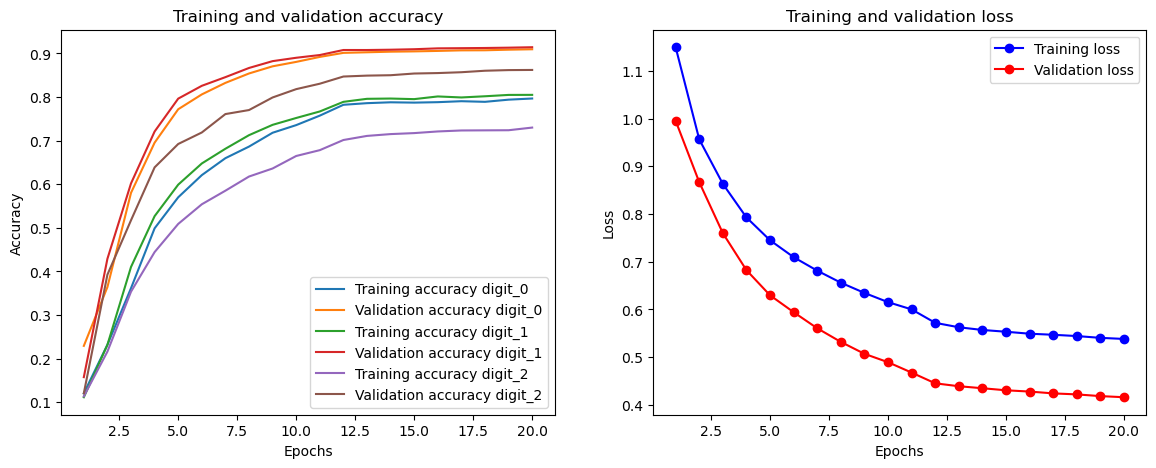

In [55]:
# Plot learning curves for the last fold
plot_learning_curves(history)

### Interpretation

The model is on the right track. Both training loss and validation loss decreasing over time, which is good, although the accuracy for digit 2 (purple lines) is lower than for digits 0 and 1.

### Training and Validation Accuracy

Although the training accuracy is slightly higher than the validation accuracy, the gap between them is not very large. 
That means the model is not overfitting.

### Training and validation Loss

The loss for both training and validation decreases significantly in the first few epochs and then stabilized, decreasing slowly.

**The lowest loss using 'binary-crossentropy' as the loss function is around  is around 0.5, which is lower than loss using 'categorical-crossentropy' as the loss function.**

### Next Plan

* Increase Model Complexity: Consider adding more layers or units to the model, especially to increase accuracy for digit 2 (purple lines).
* Hyperparameter Tuning: Experiment with different learning rates, batch sizes, and regularization techniques. Increase fold number. With more folds, the validation estimate is more robust and less variable and better Generalization.
* Using Batch Normalization to normalize the inputs to a layer for each mini-batch, to reduce the internal covariate shift.

The model is good, but requires further tuning and possibly a more complex architecture to improve its performance.

## 7/8/9. CNN Model with Activation: *_Softmax_*, Loss function: *_Binary Cross Entropy_*

### 7C. Define the Model

In [38]:
def create_cnn_model_smaxbc():
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = [Dense(10, activation='softmax', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',  # usually categorical_crossentropy is for multi-class classification, not for multi-label classification.
        optimizer='adam',
        metrics={f'digit_{i}': 'accuracy' for i in range(3)}
    )
    return model

model = create_cnn_model_smaxbc()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 13, 13,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 5, 64)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1600)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    409,856 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_0 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_2 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,382 (1.66 MB)

 Trainable params: 436,382 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

### 8C. Train the Model

In [81]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_smaxbc()  # Using CNN model with 'binary_crossentropy' function as the loss function

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=128),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - digit_0_accuracy: 0.1367 - digit_1_accuracy: 0.1359 - digit_2_accuracy: 0.1286 - loss: 2.8616 - val_digit_0_accuracy: 0.1027 - val_digit_1_accuracy: 0.0938 - val_digit_2_accuracy: 0.0930 - val_loss: 2.7829 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - digit_0_accuracy: 0.5393 - digit_1_accuracy: 0.5333 - digit_2_accuracy: 0.5015 - loss: 1.0798 - val_digit_0_accuracy: 0.3619 - val_digit_1_accuracy: 0.3368 - val_digit_2_accuracy: 0.4577 - val_loss: 1.0653 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - digit_0_accuracy: 0.8757 - digit_1_accuracy: 0.8761 - digit_2_accuracy: 0.8720 - loss: 0.4905 - val_digit_0_accuracy: 0.9036 - val_digit_1_accuracy: 0.9184 - val_digit_2_accuracy: 0.8978 - val_loss: 0.3827 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - digit_0_accuracy: 0.9250 - digit_1_accuracy: 0.9200 - digit_2_accuracy: 0.9252 - loss:

### 9C. Evaluate the model

In [1]:
# Plot learning curves for the last fold
plot_learning_curves(history)

NameError: name 'plot_learning_curves' is not defined

## **10. Hyperparameter Tuning**
- Perform 'keras-tuner' tuning to identify the best model parameters.
- Apply regularization techniques to prevent overfitting.
- Use cross-validation to obtain a more reliable estimate of the model's performance. 
- Use batch Normalization to normalize the inputs to a layer for each mini-batch. This reduces the internal covariate shift.

### Using Keras Tuner to optimize the CNN hypermodel and setting up a tuner to find the best hyperparameters.

In [99]:
def build_model(hp):
    inputs = Input(shape=(28, 28, 1))
    
    # First Convolutional Block
    x = Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001)
    )(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Third Convolutional Block
    x = Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu',
        kernel_regularizer=l2(0.001)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Output Layers
    outputs = [Dense(10, activation='softmax', name=f'digit_{i}')(x) for i in range(3)]
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        loss={'digit_0': 'binary_crossentropy', 'digit_1': 'binary_crossentropy', 'digit_2': 'binary_crossentropy'},
        optimizer='adam',
        metrics={'digit_0': 'accuracy', 'digit_1': 'accuracy', 'digit_2': 'accuracy'}
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning'
)

# Perform hyperparameter search
tuner.search(
    custom_data_generator(X_train, y_train_dict, batch_size=32),
    epochs=20,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, y_val_dict),
    callbacks=[early_stopping, lr_scheduler]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print summary of the best model and hyperparameters
print(best_hyperparameters.values)

Trial 20 Complete [00h 22m 29s]
val_loss: 0.07059618085622787

Best val_loss So Far: 0.06173119693994522
Total elapsed time: 05h 47m 46s
 
{'conv_1_filters': 96, 'conv_2_filters': 128, 'conv_3_filters': 128, 'dense_units': 256}


### Create CNN Model using the best hyperparameters obtained from the tuning process

In [139]:
def create_cnn_model_smaxbch():
    inputs = Input(shape=(28, 28, 1))  # Input shape for a 28x28 grayscale image
    
    # First Convolutional Block with best hyperparameters
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Convolutional Block with best hyperparameters
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third Convolutional Block with best hyperparameters
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Fully Connected Layers with best hyperparameters
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layers
    outputs = [Dense(10, activation='sigmoid', name=f'digit_{i}')(x) for i in range(3)]
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compiling the model
    model.compile(
        loss={'digit_0': 'binary_crossentropy', 'digit_1': 'binary_crossentropy', 'digit_2': 'binary_crossentropy'},
        optimizer='adam',
        metrics={'digit_0': 'accuracy', 'digit_1': 'accuracy', 'digit_2': 'accuracy'}
    )
    
    return model

model = create_cnn_model_smaxbch()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 28, 28, 96)        │             960 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 28, 28, 96)        │             384 │ conv2d_15[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 14, 14, 96)        │               0 │ batch_normalization_20[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_20 (Dropout)          │ (None, 14, 14, 96)        │               0 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_16 (Conv2D)            │ (None, 14, 14, 128)       │         110,720 │ dropout_20[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_21        │ (None, 14, 14, 128)       │             512 │ conv2d_16[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_16              │ (None, 7, 7, 128)         │               0 │ batch_normalization_21[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_21 (Dropout)          │ (None, 7, 7, 128)         │               0 │ max_pooling2d_16[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 7, 7, 128)         │         147,584 │ dropout_21[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_22        │ (None, 7, 7, 128)         │             512 │ conv2d_17[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_17              │ (None, 3, 3, 128)         │               0 │ batch_normalization_22[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_22 (Dropout)          │ (None, 3, 3, 128)         │               0 │ max_pooling2d_17[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_5 (Flatten)           │ (None, 1152)              │               0 │ dropout_22[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 564,574 (2.15 MB)

 Trainable params: 563,358 (2.15 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [133]:
# Increase K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True)

In [135]:
#Adjust learning rate scheduler 
def lr_schedule(epoch):
    lr = 1e-5
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    return lr

In [141]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

    model = create_cnn_model_smaxbch()  # Using CNN model using the best hyperparameters obtained from the tuning process

    history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=32),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 172s 102ms/step - digit_0_accuracy: 0.3593 - digit_1_accuracy: 0.3534 - digit_2_accuracy: 0.3396 - loss: 1.7398 - val_digit_0_accuracy: 0.9415 - val_digit_1_accuracy: 0.9393 - val_digit_2_accuracy: 0.9436 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 158s 99ms/step - digit_0_accuracy: 0.9250 - digit_1_accuracy: 0.9251 - digit_2_accuracy: 0.9264 - loss: 0.3639 - val_digit_0_accuracy: 0.9635 - val_digit_1_accuracy: 0.9528 - val_digit_2_accuracy: 0.9605 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 168s 105ms/step - digit_0_accuracy: 0.9368 - digit_1_accuracy: 0.9348 - digit_2_accuracy: 0.9383 - loss: 0.3495 - val_digit_0_accuracy: 0.9654 - val_digit_1_accuracy: 0.9631 - val_digit_2_accuracy: 0.9659 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 172s 107ms/step - digit_0_accuracy: 0.9439 - digit_1_accuracy: 0.9459 - digit_2_accuracy:

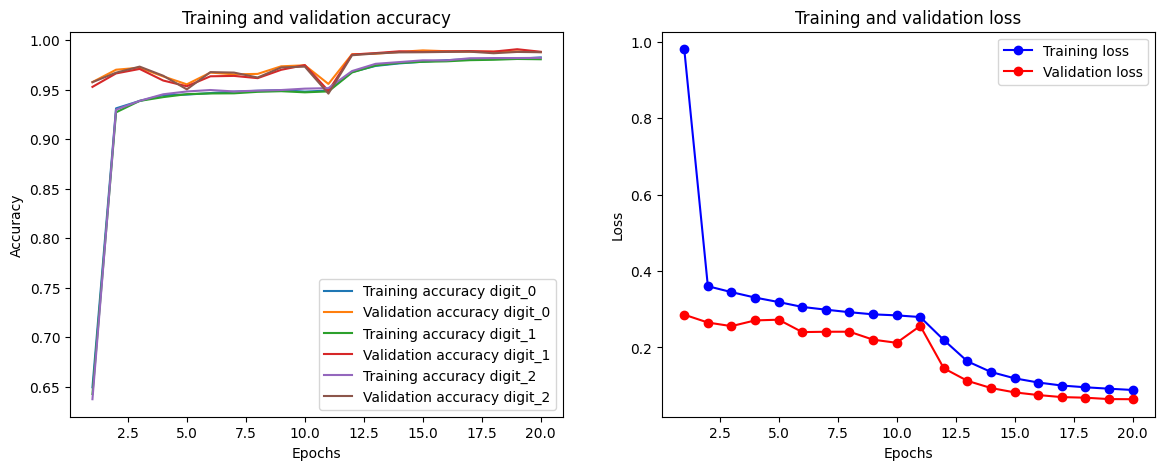

In [142]:
# Plot learning curves for the last fold
plot_learning_curves(history)

## 11. Re-Evaluate The Model

### Interpretation

There are some fluctuations in the early epochs, but overall, the training and validation accuracies are close to each other. 
The model is showing improvement and better performance after hyperparameter tuning. The tuning made the model way better. 

Both training and validation accuracies are higher, and losses are lower.

### Training and Validation Accuracy

* The training accuracy has gotten better and keeps going up more than 96%. It means the model is learning more about the digits.
* The validation accuracy is also getting better and follows the training accuracy closely. This means the model isn’t just memorizing the training data but is also good at predicting new data. The validation accuracy goes up to about the same level as the training accuracy, which is great because it shows there’s no overfitting.

### Training and validation Loss

* The training loss keeps going down, showing the model is making fewer mistakes on the training data.
* There’s a drop around epoch 2-3. After that, the loss keeps going down but a bit slower.
* The validation loss is also going down and matches the training loss trend. This means the model is doing better on new data too.
* The validation loss is close to the training loss, which is good, because it means the model is not overfitting.

The lowest loss using _Binary Cross Entropy_ as the loss function is around  is around 0.1, which is lower than loss using _Categorical Cross Entropy_ as the loss function.

### Interpretation

The model achieves the ***highest accuracy on the test set*** when using the ***Softmax activation function and binary crossentropy for the loss function***, as opposed to using the sigmoid activation function with the same loss function.

The optimal parameters, based on Keras Tuner, are:

```{'conv_1_filters': 96, 'conv_2_filters': 128, 'conv_3_filters': 128, 'dense_units': 256}```

In [161]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 31500), started 6 days, 23:59:43 ago. (Use '!kill 31500' to kill it.)

### Final evaluation on the test set using CNN model with Activation: _Softmax_, Loss function: _Binary Cross Entropy_

In [143]:
# Final evaluation on the test set Using CNN model with Softmax activation function and binary crossentropy
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold = {key: y_train_dict[key][train_index] for key in y_train_dict}
    y_val_fold = {key: y_train_dict[key][val_index] for key in y_train_dict}

model = create_cnn_model_smaxbch()   

history = model.fit(
        custom_data_generator(X_train_fold, y_train_fold, batch_size=32),
        epochs=20, verbose=1, steps_per_epoch=len(X_train_fold) // 32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback]    )

# Evaluate the model on the test set
test_metrics = model.evaluate(X_test, y_test_dict)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1:]

print(f'Test loss: {test_loss}')
for i, acc in enumerate(test_accuracy):
    print(acc)

Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 242s 146ms/step - digit_0_accuracy: 0.3592 - digit_1_accuracy: 0.3520 - digit_2_accuracy: 0.3429 - loss: 1.7357 - val_digit_0_accuracy: 0.9587 - val_digit_1_accuracy: 0.9473 - val_digit_2_accuracy: 0.9458 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 240s 150ms/step - digit_0_accuracy: 0.9294 - digit_1_accuracy: 0.9254 - digit_2_accuracy: 0.9241 - loss: 0.3586 - val_digit_0_accuracy: 0.9591 - val_digit_1_accuracy: 0.9566 - val_digit_2_accuracy: 0.9534 - val_loss: 0.3053 - learning_rate: 0.0010
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 236s 148ms/step - digit_0_accuracy: 0.9360 - digit_1_accuracy: 0.9381 - digit_2_accuracy: 0.9400 - loss: 0.3466 - val_digit_0_accuracy: 0.9562 - val_digit_1_accuracy: 0.9532 - val_digit_2_accuracy: 0.9591 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 242s 151ms/step - digit_0_accuracy: 0.9422 - digit_1_accuracy: 0.9422 - digit_2_accuracy

## Confusion Matrix

In [147]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Confusion matrix for each digit

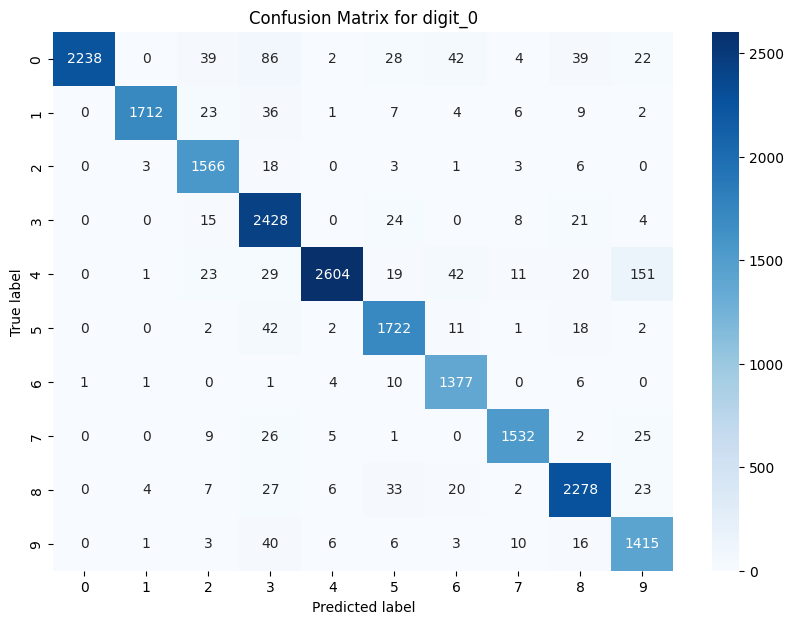

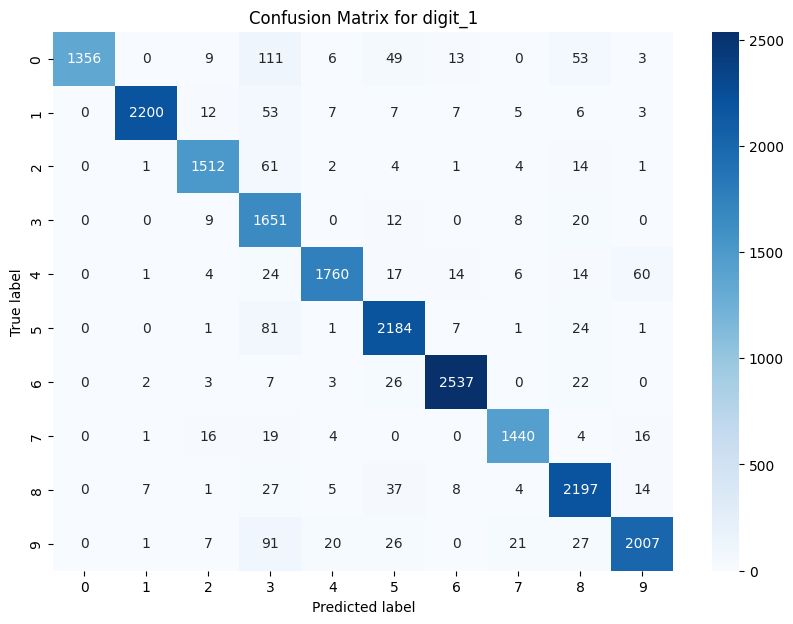

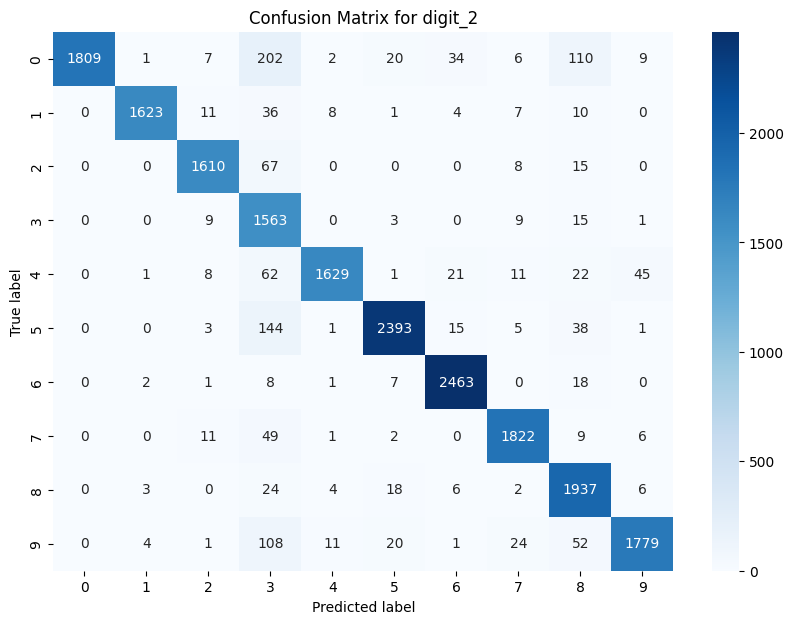

In [159]:
for i in range(3):    
    cm = confusion_matrix(y_test_indices[i], y_pred_indices[i])
    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for digit_{i}')

## Classification report for each digit

In [157]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to label indices
y_pred_indices = [np.argmax(y, axis=1) for y in y_pred]
y_test_indices = [np.argmax(y, axis=1) for y in y_test_dict.values()]

class_names = [str(i) for i in range(10)] # Define class names (digits 0-9)

for i in range(3):
    print(f"Classification Report for digit_{i}:")
    print(classification_report(y_test_indices[i], y_pred_indices[i], target_names=class_names))    

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step
Classification Report for digit_0:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      2500
           1       0.99      0.95      0.97      1800
           2       0.93      0.98      0.95      1600
           3       0.89      0.97      0.93      2500
           4       0.99      0.90      0.94      2900
           5       0.93      0.96      0.94      1800
           6       0.92      0.98      0.95      1400
           7       0.97      0.96      0.96      1600
           8       0.94      0.95      0.95      2400
           9       0.86      0.94      0.90      1500

    accuracy                           0.94     20000
   macro avg       0.94      0.95      0.94     20000
weighted avg       0.95      0.94      0.94     20000

Classification Report for digit_1:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1600
           1       

## Feature Maps Visualization

In [36]:
def build_model_for_feature_maps(input_shape, num_classes, conv_1_filters, conv_2_filters, conv_3_filters, dense_units, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(filters=conv_1_filters, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional layer
    model.add(Conv2D(filters=conv_2_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional layer
    model.add(Conv2D(filters=conv_3_filters, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Dense layer
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(units=num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model 

In [37]:
# Set optimal hyperparameters
input_shape = (28, 28, 1)
num_classes = 10
optimal_params = {
    'conv_1_filters': 96,
    'conv_2_filters': 128,
    'conv_3_filters': 128,
    'dense_units': 256
}

# Build and summarize the model
model_for_feature_maps = build_model_for_feature_maps(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_1_filters=optimal_params['conv_1_filters'],
    conv_2_filters=optimal_params['conv_2_filters'],
    conv_3_filters=optimal_params['conv_3_filters'],
    dense_units=optimal_params['dense_units']
)
model_for_feature_maps.summary()
history = model_for_feature_maps.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,858 (1.12 MB)

 Trainable params: 294,858 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 53s 26ms/step - accuracy: 0.3632 - loss: 0.2608 - val_accuracy: 0.8971 - val_loss: 0.0555
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 53s 26ms/step - accuracy: 0.9018 - loss: 0.0561 - val_accuracy: 0.9236 - val_loss: 0.0417
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - accuracy: 0.9303 - loss: 0.0383 - val_accuracy: 0.9316 - val_loss: 0.0369
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9461 - loss: 0.0306 - val_accuracy: 0.9424 - val_loss: 0.0322
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9524 - loss: 0.0268 - val_accuracy: 0.9396 - val_loss: 0.0340
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - accuracy: 0.9596 - loss: 0.0230 - val_accuracy: 0.9361 - val_loss: 0.0360
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.9629 - loss: 0.0209 - val_accuracy: 0.9452 - val_loss: 0.0321
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 53s 26ms/step - accuracy: 0.9672 -

In [38]:
layer = model_for_feature_maps.layers
filters, biases = model_for_feature_maps.layers[2].get_weights()
print(layer[2].name, filters.shape)

conv2d_1 (3, 3, 96, 128)


In [64]:
import matplotlib.pyplot as plt

def plot_filters(filters, columns=8, rows=8, channel=0):
    """
    Plot filters from a convolutional layer.

    Parameters:
    filters (numpy.ndarray): The filters to be visualized, expected shape (filter_height, filter_width, input_channels, num_filters).
    columns (int): Number of columns in the plot grid. Default is 8.
    rows (int): Number of rows in the plot grid. Default is 8.
    channel (int): The channel of the filter to be visualized. Default is 0.
    """
    fig1 = plt.figure(figsize=(columns * 2, rows * 2))  # Adjust figure size based on the number of rows and columns
    n_filters = min(columns * rows, filters.shape[3])  # Ensure we don't exceed the number of available filters

    for i in range(1, n_filters + 1):
        f = filters[:, :, :, i - 1]

        ax = fig1.add_subplot(rows, columns, i)
        ax.set_xticks([])  # Turn off axis
        ax.set_yticks([])

        plt.imshow(f[:, :, channel], cmap='gray')  # Show only the filters from the specified channel
        ax.set_title(f'Filter {i}', fontsize=8)  # Add filter name as the plot heading

    plt.tight_layout()
    plt.show()

Layer name: conv2d, Filters shape: (3, 3, 1, 96), Biases shape: (96,)


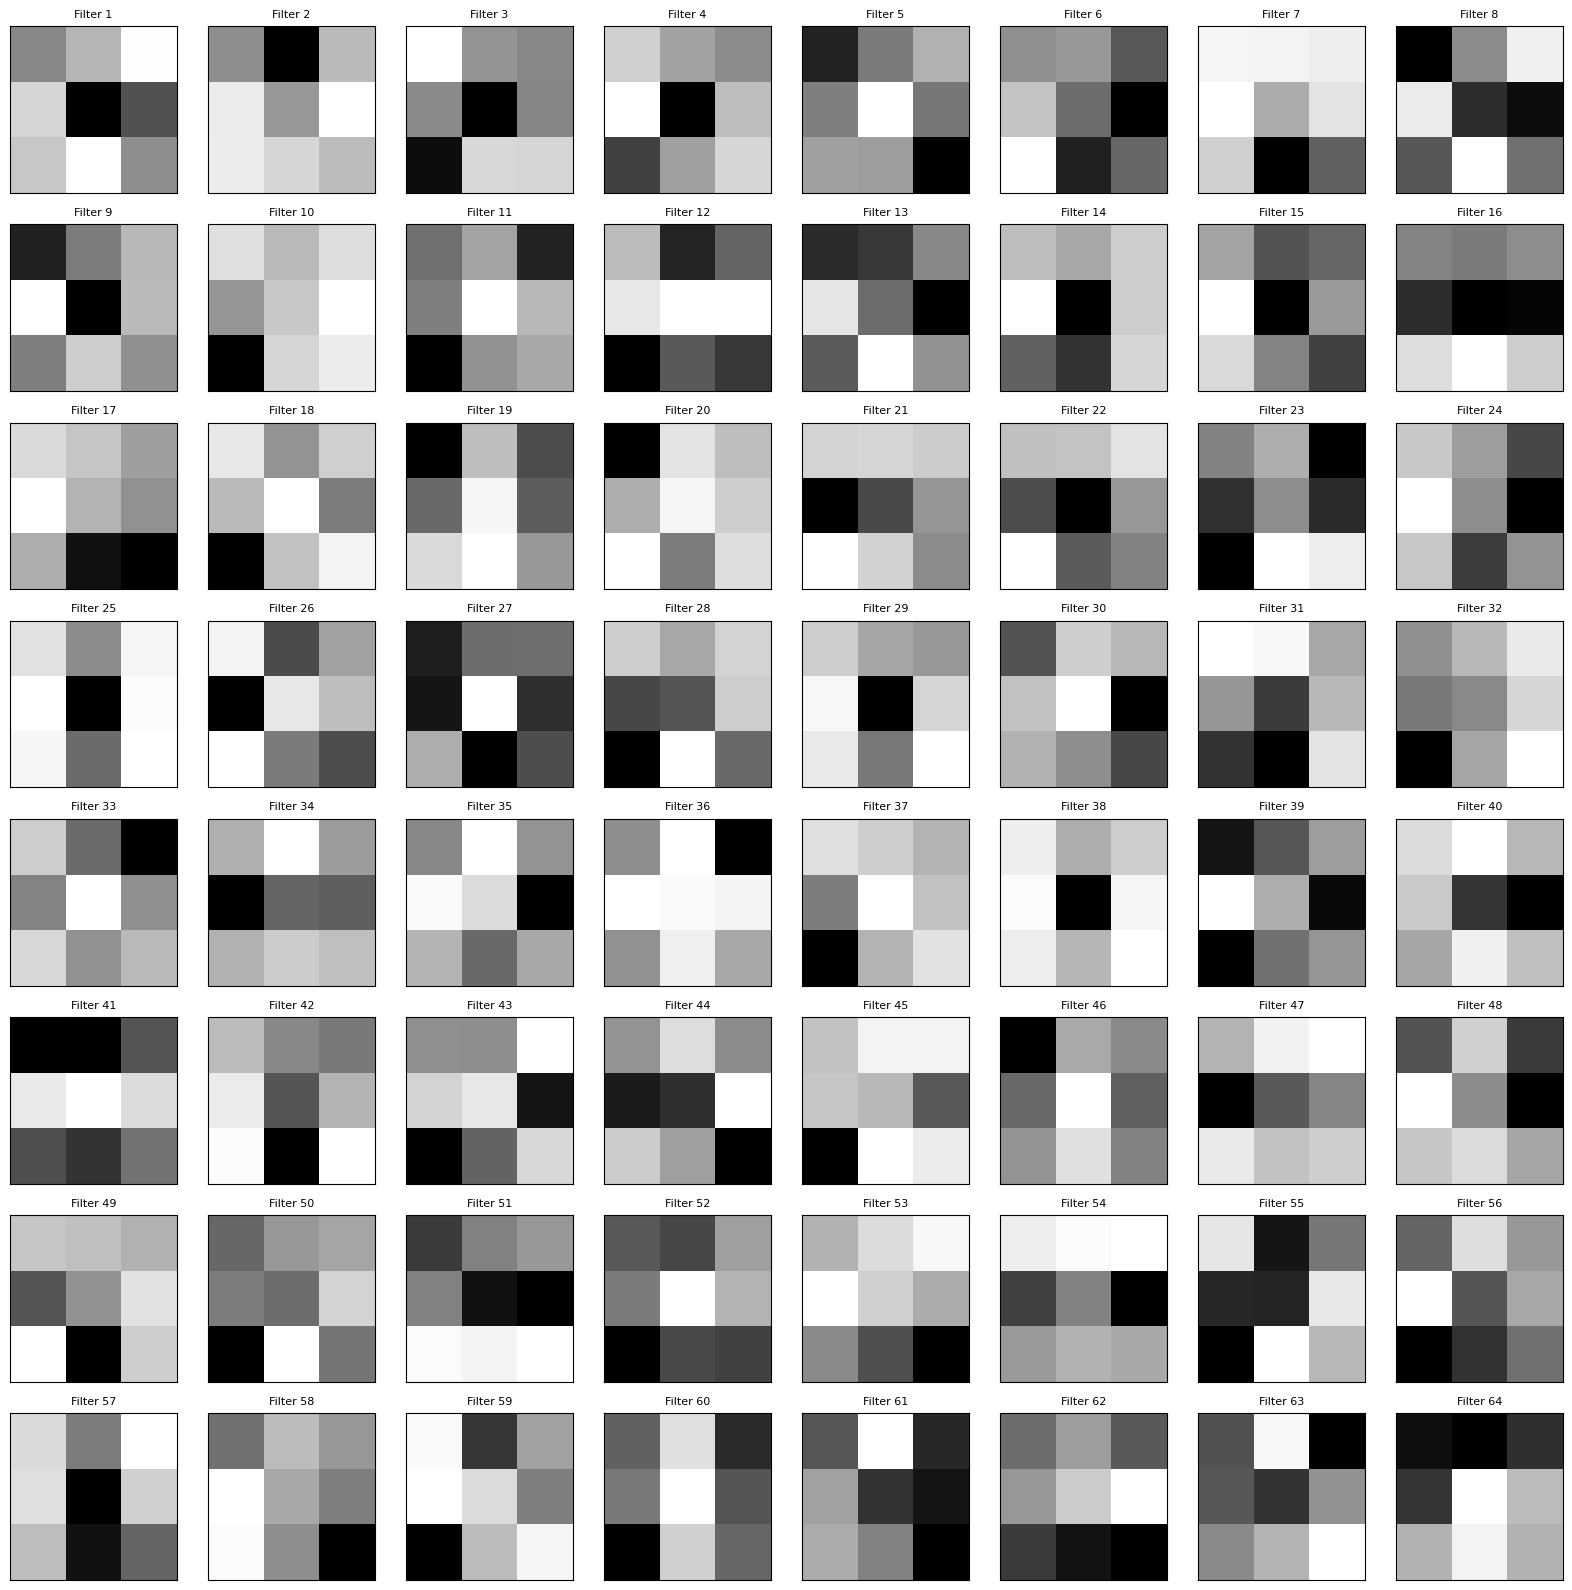

Layer name: conv2d_1, Filters shape: (3, 3, 96, 128), Biases shape: (128,)


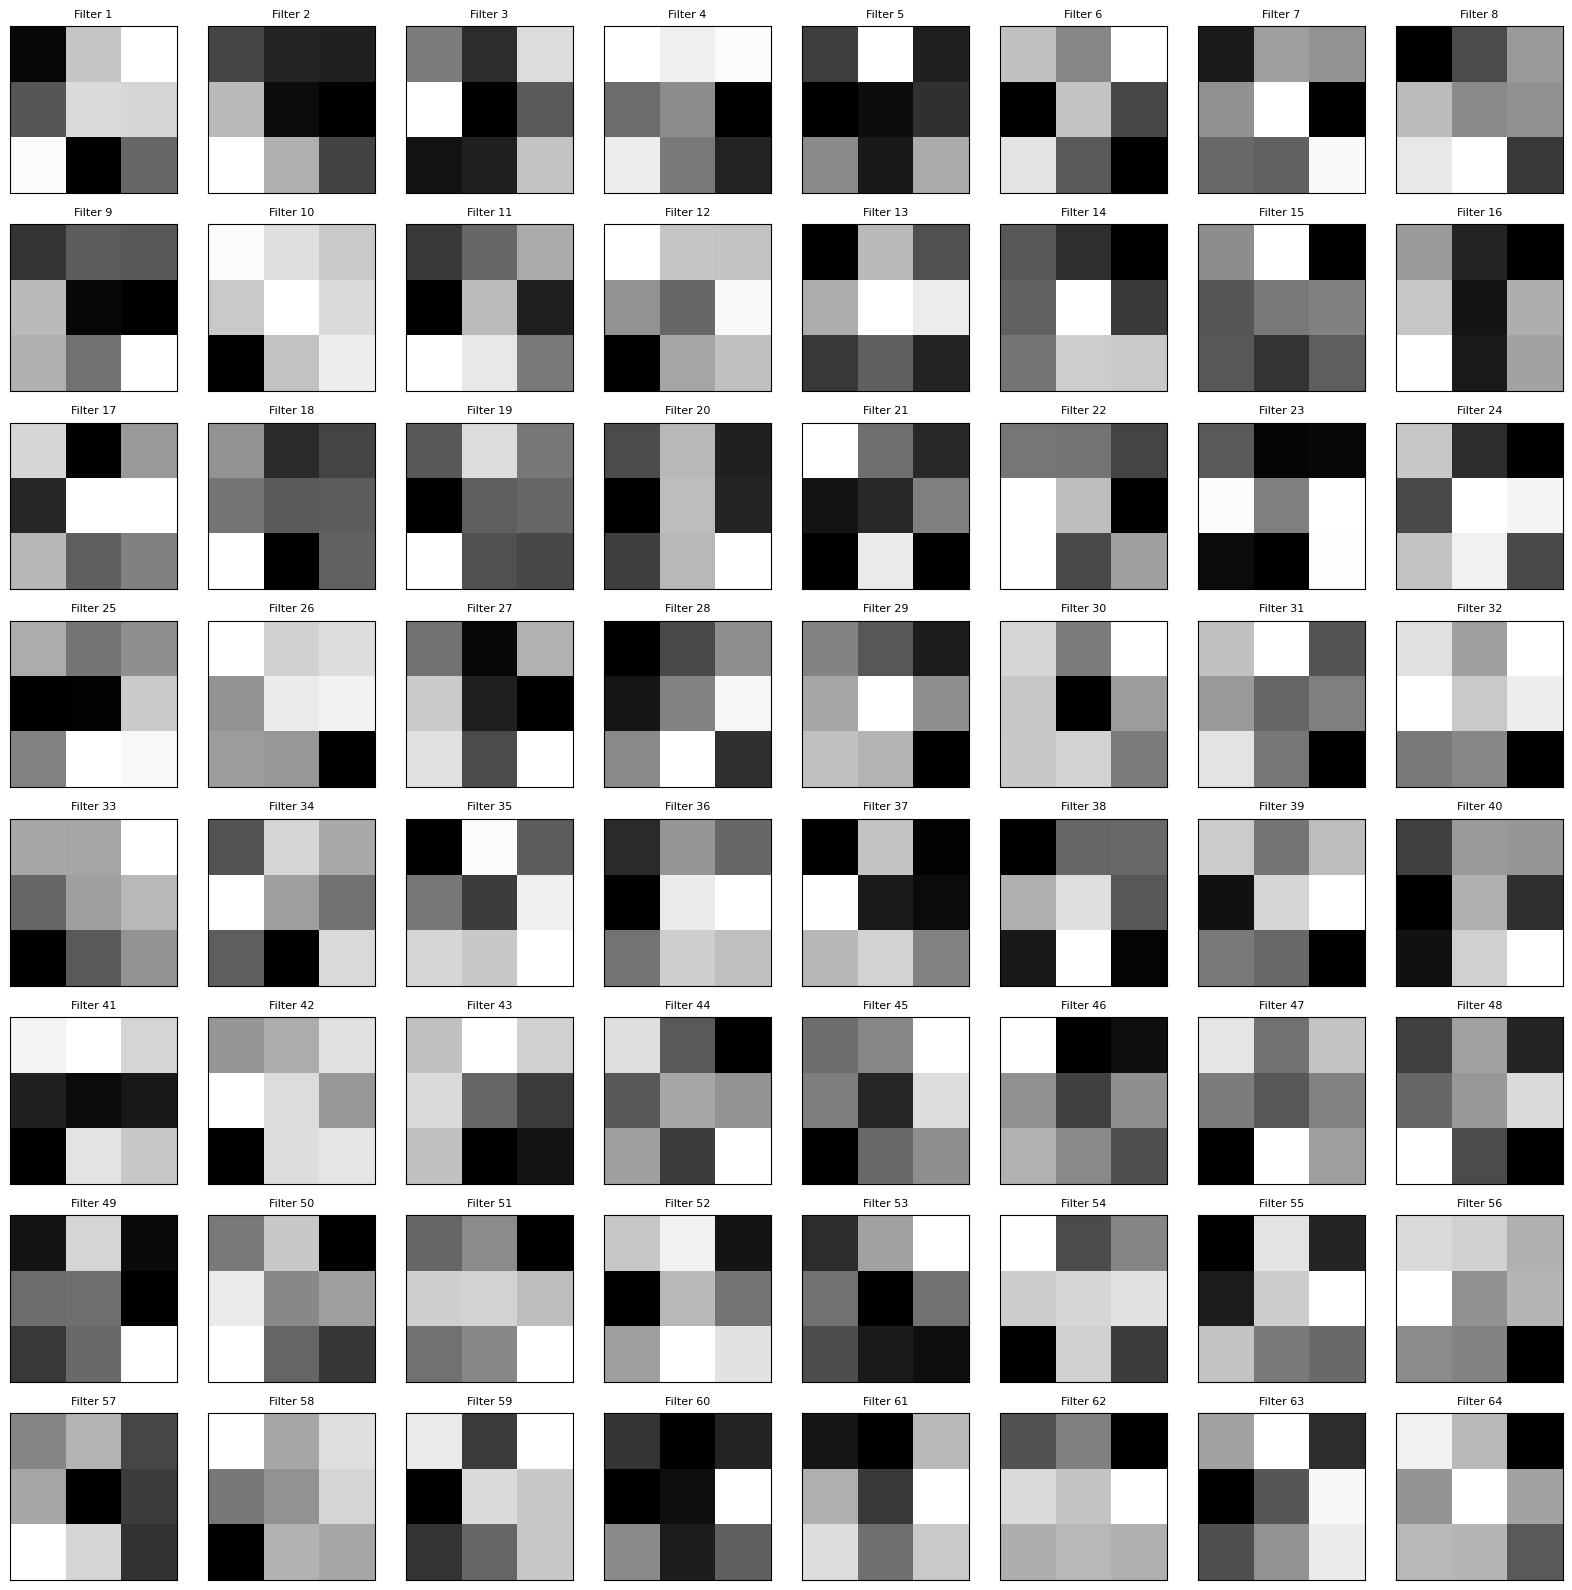

Layer name: conv2d_2, Filters shape: (3, 3, 128, 128), Biases shape: (128,)


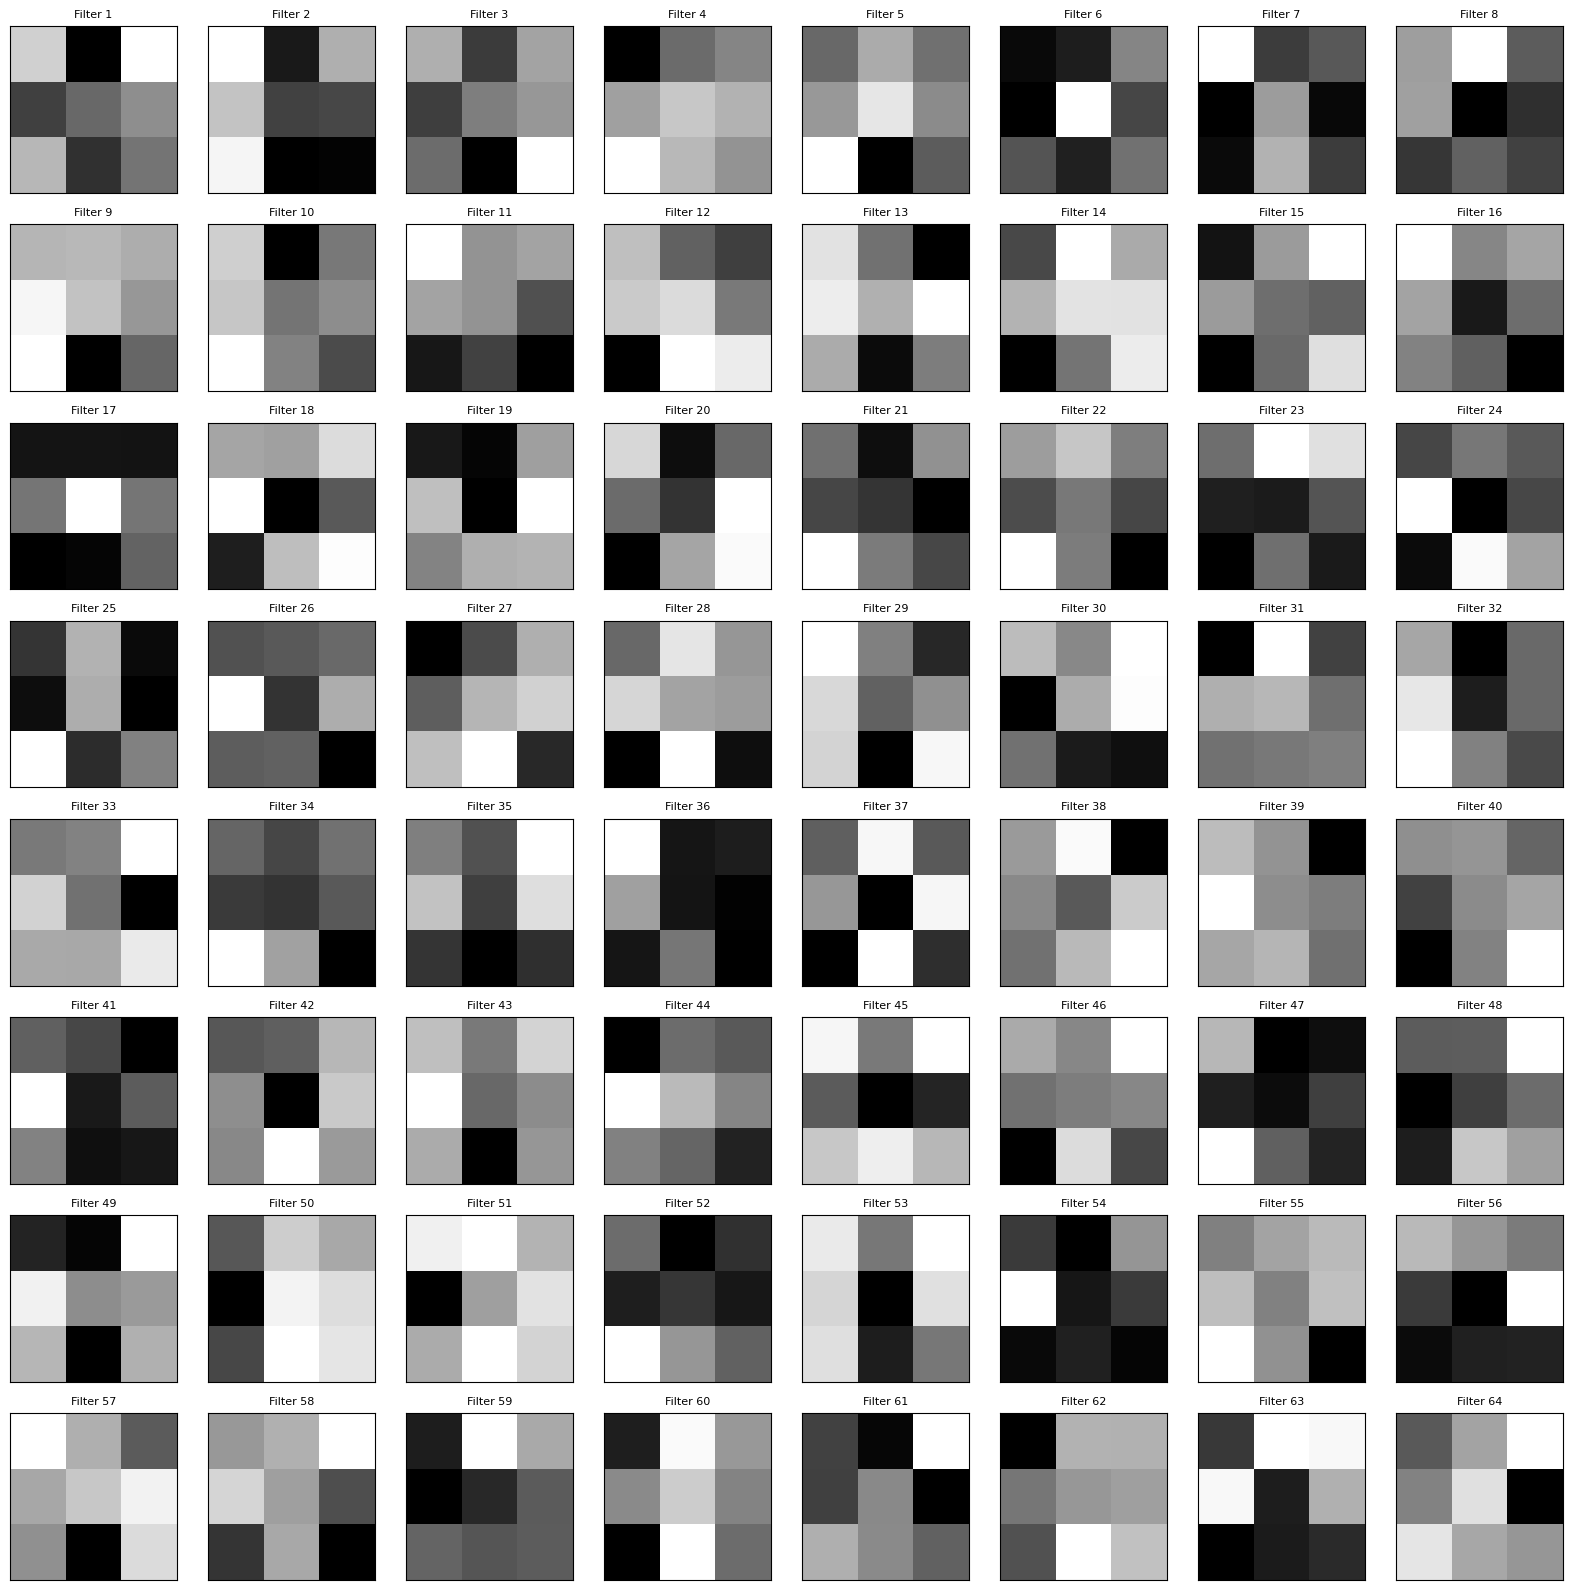

In [65]:
# Iterate through all layers in the model
for layer in model_for_feature_maps.layers:
    # Check if the layer is a Conv2D layer
    if isinstance(layer, Conv2D):
        # Get the filters and biases
        filters, biases = layer.get_weights()
        # Print the name of the layer and the shape of the filters
        print(f"Layer name: {layer.name}, Filters shape: {filters.shape}, Biases shape: {biases.shape}")
        plot_filters(filters)

In [43]:
conv_layer_index = [0, 2, 4]
outputs = [model_for_feature_maps.layers[i].output for i in conv_layer_index]

model_short = Model(inputs = model_for_feature_maps.inputs, outputs = outputs)
print(model_short.summary())

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26,    │        960 │ input_layer[0][0… │
│                     │ 96)               │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 13, 13,    │          0 │ conv2d[2][0],     │
│ (MaxPooling2D)      │ 96)               │            │ conv2d[4][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │    110,720 │ max_pooling2d[1]… │
│                     │ 128)              │            │ max_pooling2d[3]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 128) │          0 │ conv2d_1[2][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 128) │    147,584 │ max_pooling2d_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 259,264 (1012.75 KB)

 Trainable params: 259,264 (1012.75 KB)

 Non-trainable params: 0 (0.00 B)

None


We randomly picked an image from the train folder 15_430 to visualize how the model how the convolutional layers.

In [44]:
img = load_img(r'15_430.png', target_size=(28,28))

# Convert the image to an array
img_array = img_to_array(img)

# Convert RGB image to grayscale
img_gray = rgb_to_grayscale(img_array)

# Expand dimensions to match the expected input shape (1, 28, 28, 1)
img_gray = np.expand_dims(img_gray, axis=0)

In [45]:
feature_output = model_short.predict(img_gray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


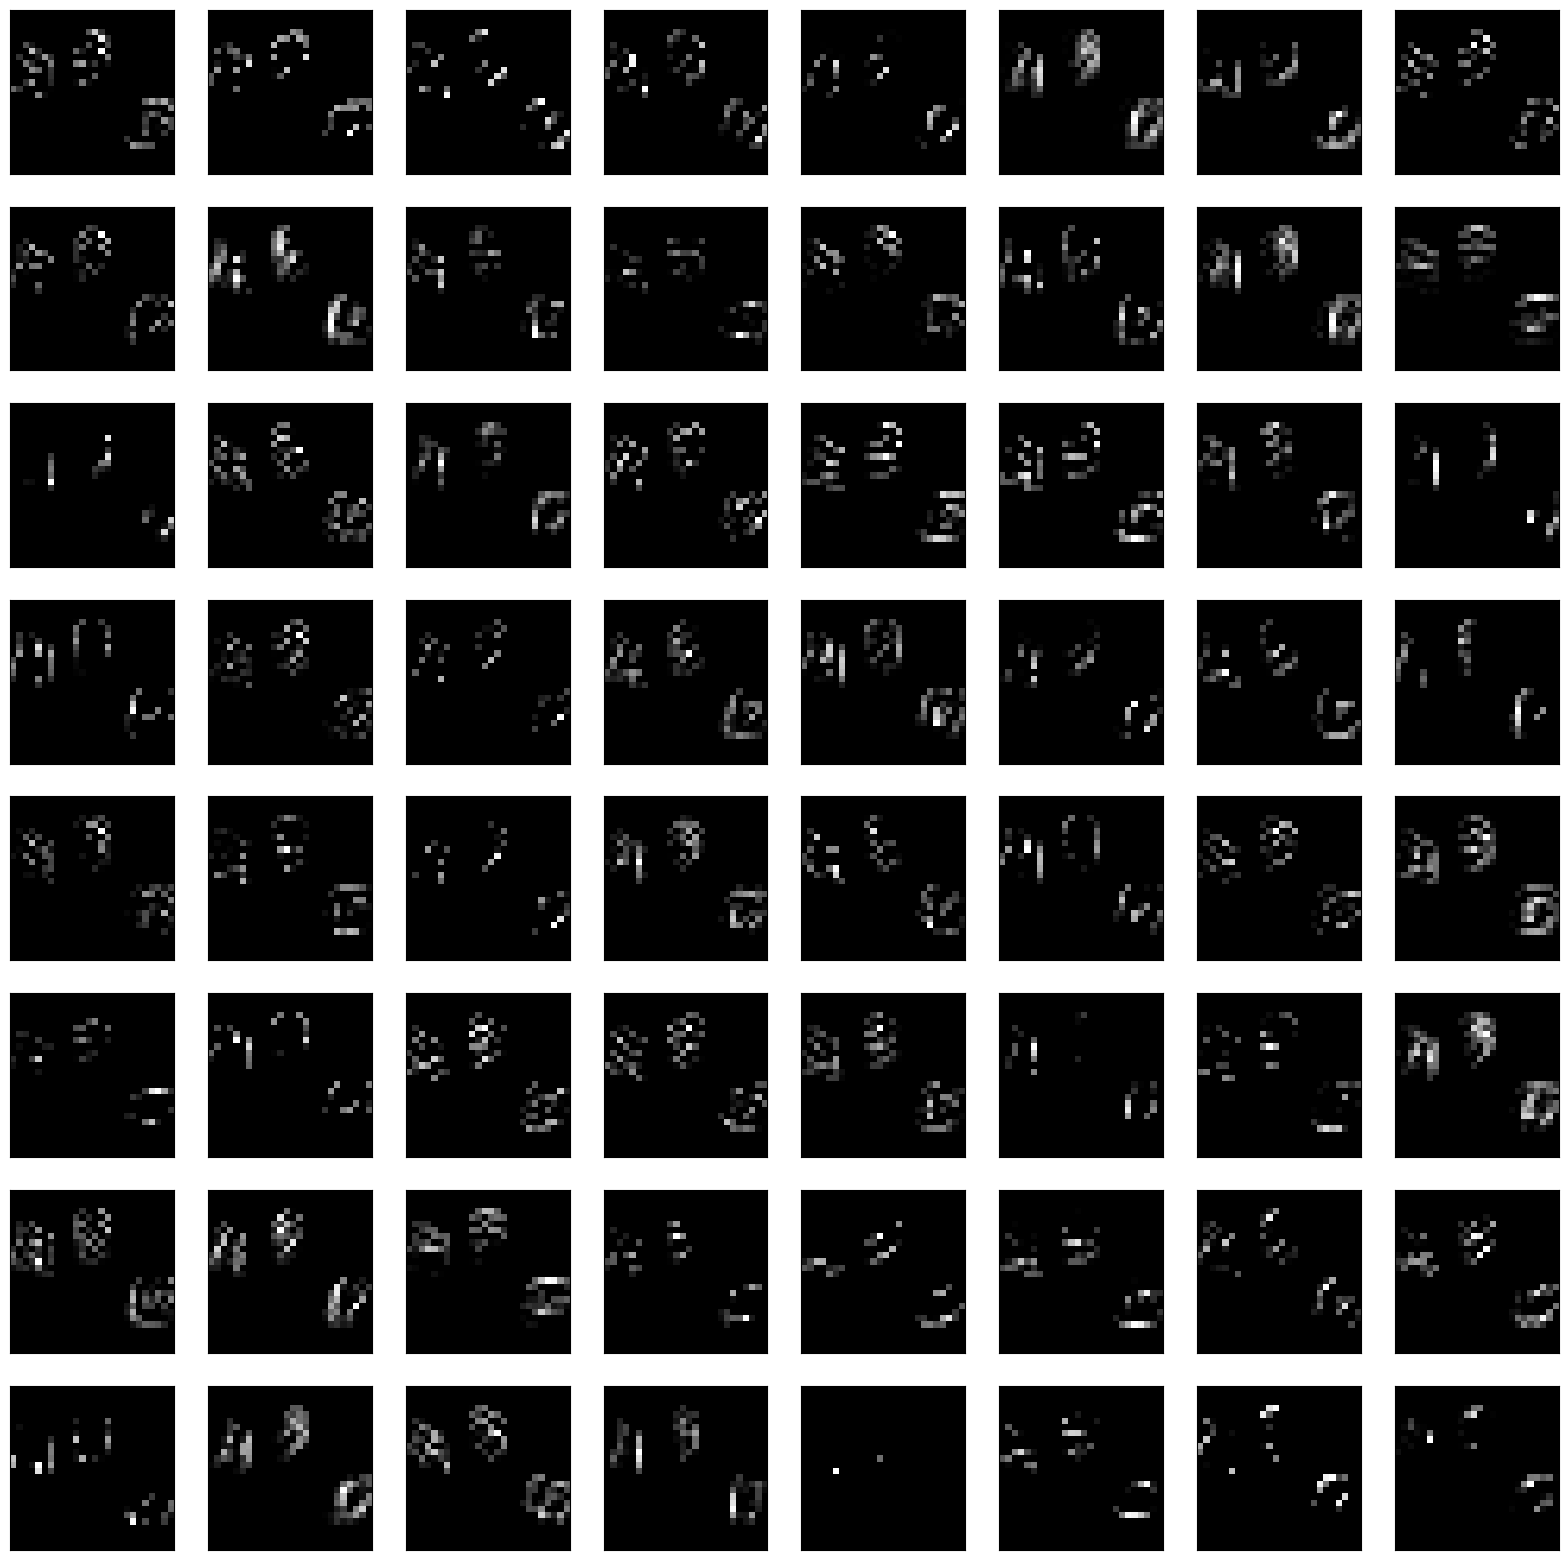

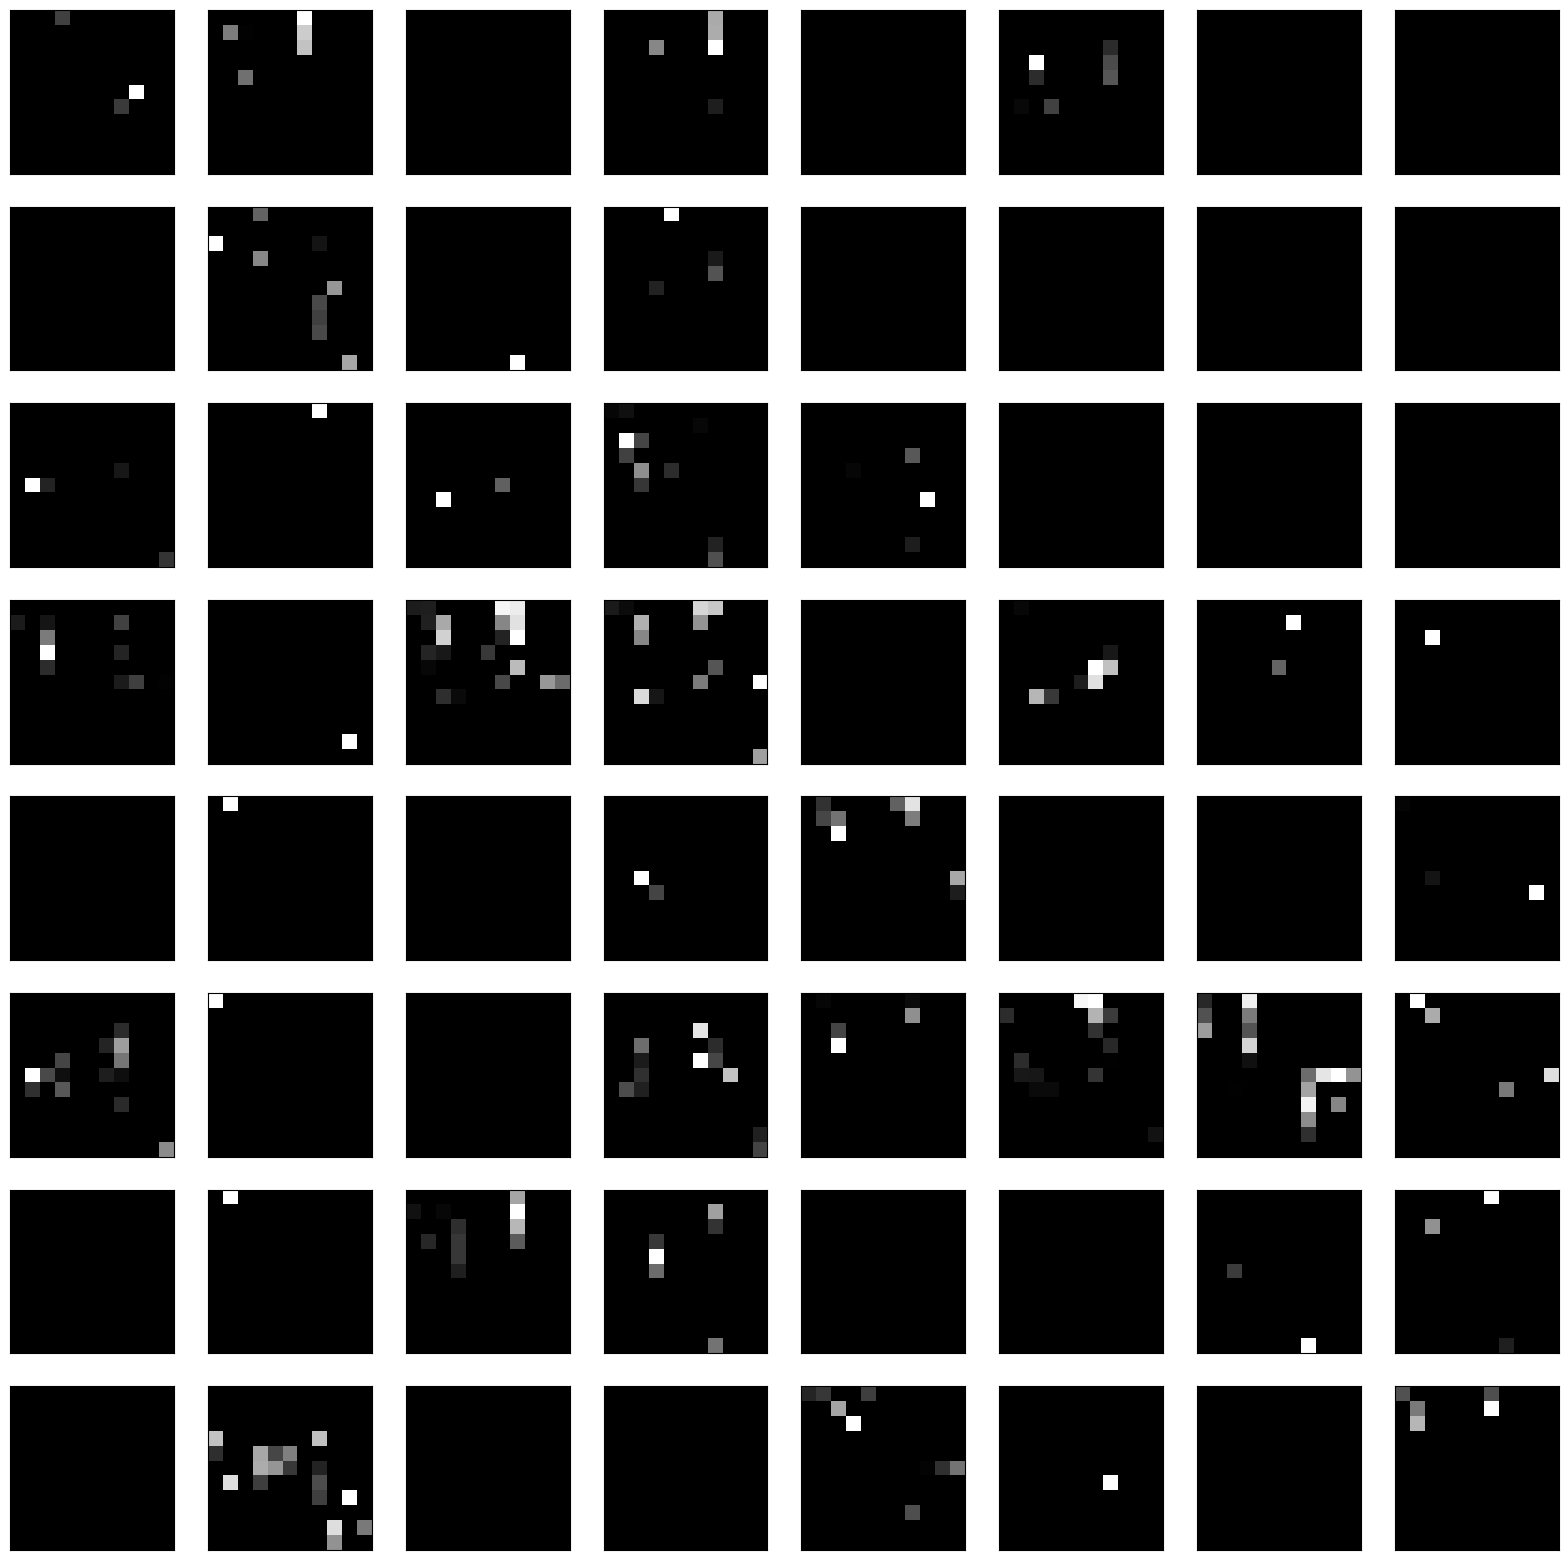

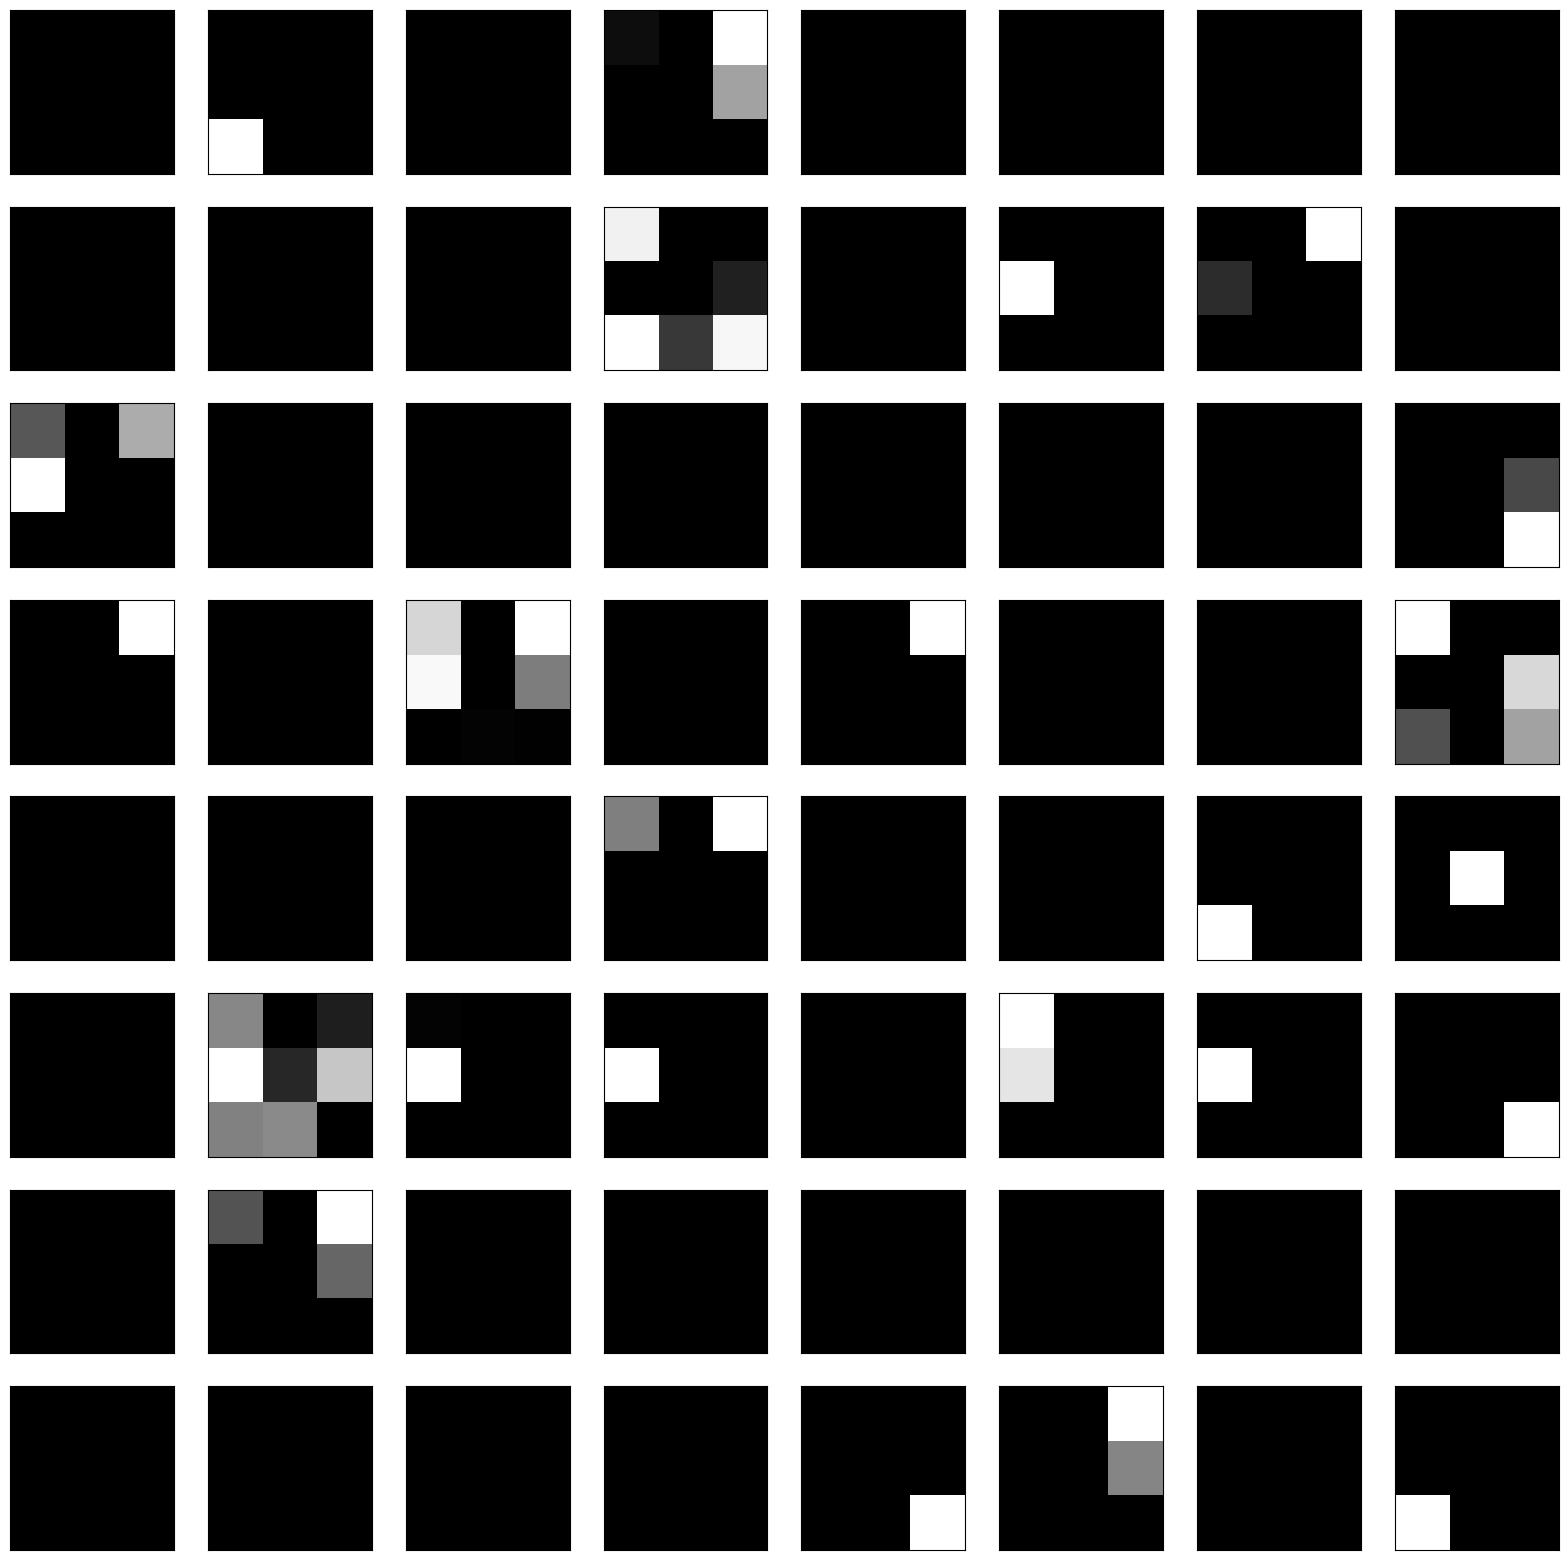

In [52]:
columns = 8
rows = 8

for feature in feature_output:
    fig = plt.figure(figsize=(20, 20))
    max_index = min(columns * rows, feature.shape[3])

    for i in range(max_index):
        ax = plt.subplot(rows, columns, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature[0, :, :, i], cmap='gray')

    plt.show()

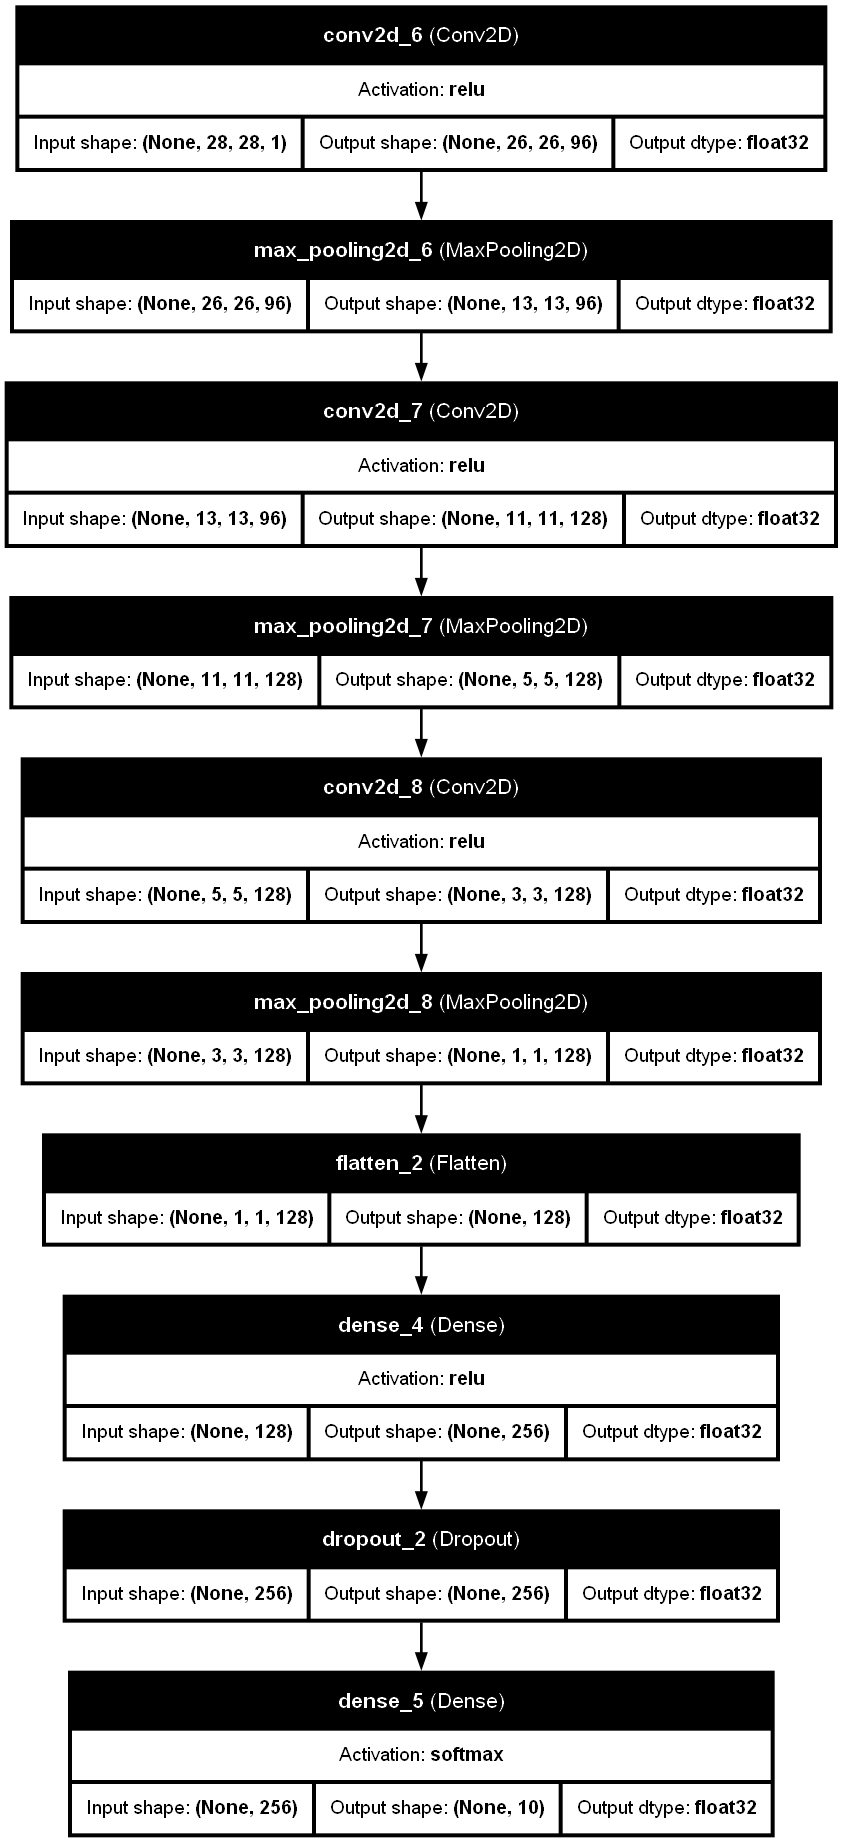

In [68]:
# Visualize the model architecture with more parameters
plot_model(
    model_for_feature_maps,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # 'TB' means top to bottom, 'LR' means left to right
    dpi=96,        # Dots per inch for the output image
    expand_nested=True,  # Expand nested models into clusters in the plot
    show_dtype=True,     # Display layer dtypes
    layer_range=None,    # List of layers to display (None means all layers)
    show_layer_activations=True  # Display layer activation functions
)

In [69]:
model_for_feature_maps.save('model.h5')